# Energy resolution after  delta-z effect correction

## DEMO Run7, esmeralda: 8757, 8758, 8759 @gpu1next


### Nov 2020, JAH

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [13]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [14]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [15]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Apr 14 12:11:21 2021


### load data

In [16]:
filename  = f'/home/hernando/data/demo/run7/dfesme_fidutial_combined.h5'
dft       = pd.read_hdf(filename, 'esme')
print('total number of events ', len(dft))

total number of events  913222


### Inspect DF

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map', 'run']


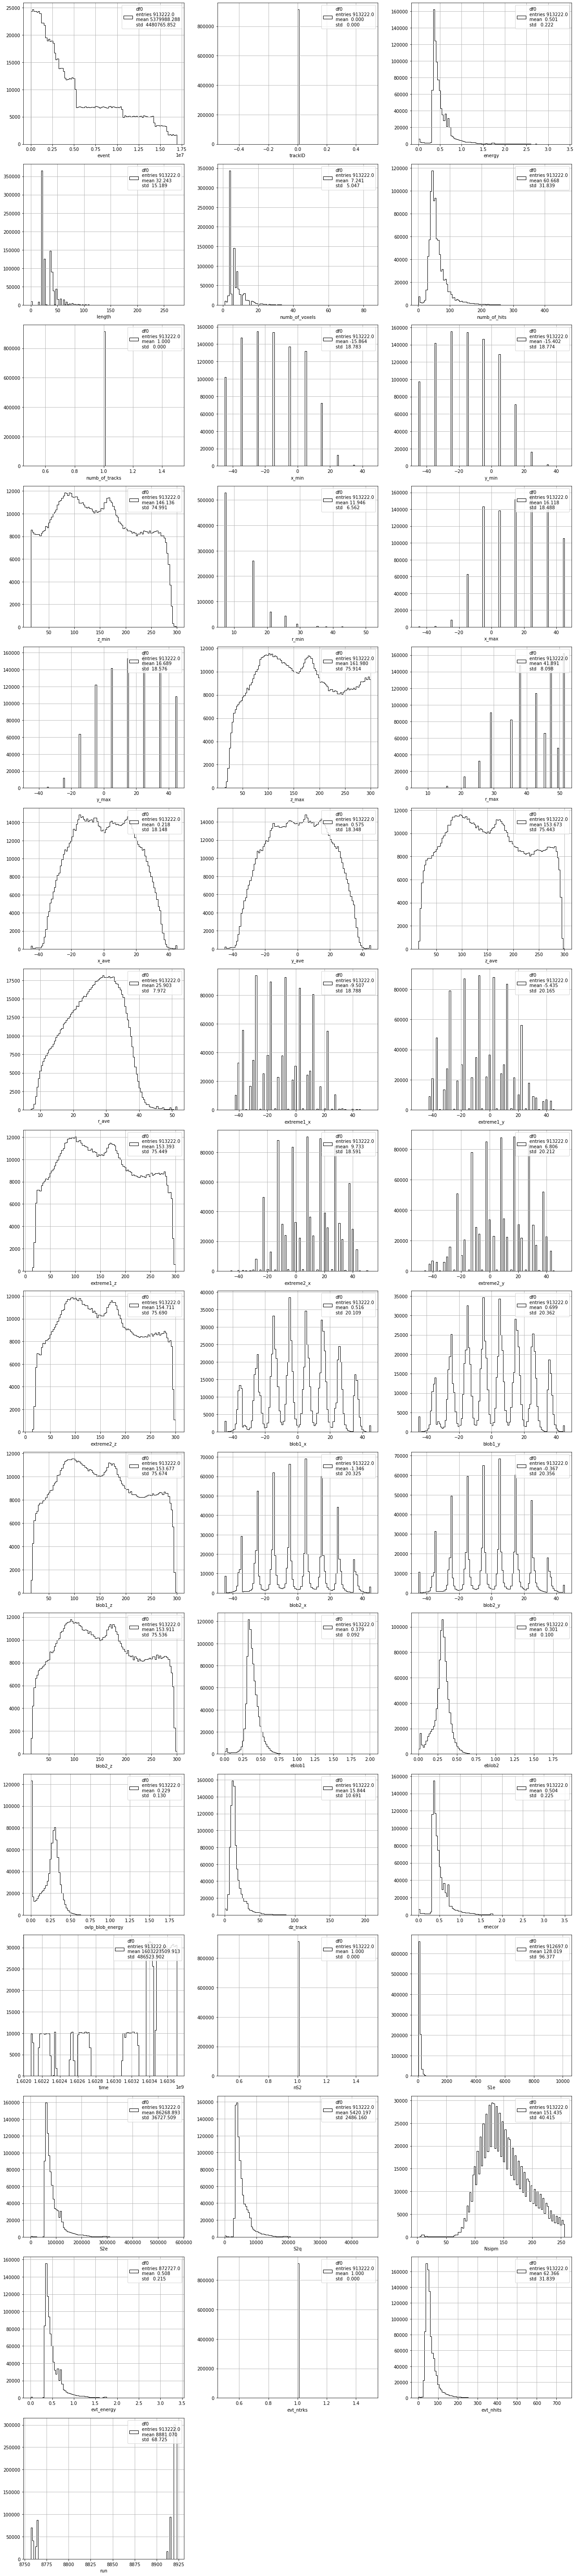

In [26]:
columns = list(dft.columns)
print(columns)
i = columns.index('evt_out_of_map') # problems with plotting, remove from the list to plot
columns.pop(i)
pltext.df_inspect(dft, columns, ncolumns = 3)

### selections and ranges

In [27]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.65, 0.75),
          'energy.ds'      : (1.60, 1.85),
          'energy.ph'      : (2.00, 3.00),
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.65, 0.75)
energy.ds (1.6, 1.85)
energy.ph (2.0, 3.0)


In [28]:
selections = nsel.Selections(dft, ranges)

            names    eff  ueff
0             nS2  100.0   0.0
1  numb_of_tracks  100.0   0.0
2           z_min  100.0   0.0
3           z_max  100.0   0.0
4           r_max  100.0   0.0


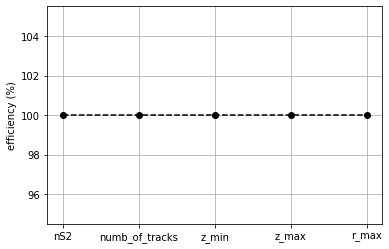

In [29]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max') 
sels        = [selections[selname] for selname in selnames]
effs, ueffs = eres.efficiencies(sels, selnames, True)
df = pd.DataFrame({'names' : selnames, 'eff' : effs, 'ueff' : ueffs})
print(df)

In [30]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max')
selections.logical_and(selnames, 'fidutial');

In [32]:
#pltext.df_inspect(dft[selections['fidutial']], columns[:-1], ncolumns = 3)

### Energy 

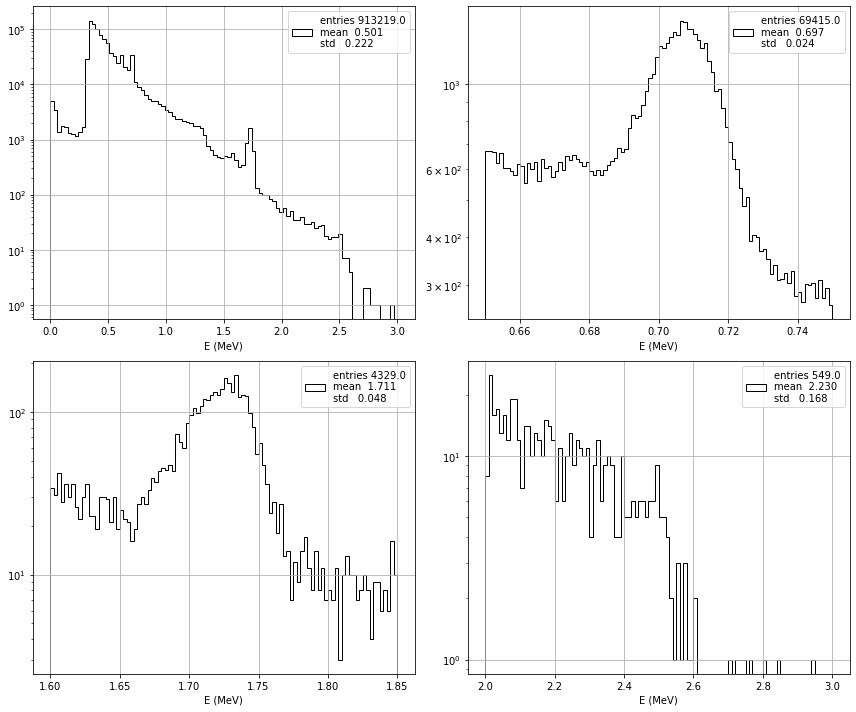

In [33]:
def plt_energies(enes, ranges, bins = 100):

    nplots = len(ranges)

    subplot = pltext.canvas(nplots, 2)
    
    for i in range(nplots):
        subplot( i + 1)
        pltext.hist(enes, bins, range = ranges[i], ylog = True, xylabels = 'E (MeV)'); 
    plt.tight_layout()

sel     = selections['fidutial']
eranges = [ranges[name] for name in ('energy', 'energy.cs', 'energy.ds', 'energy.ph')]
plt_energies(dft.energy[sel], eranges)
#plt_energies(dft.energy)

(0.7071332558604789, 0.009035608872745458, 0.00010149053678724949, 3.002783517105769, 0.03372812118132005)
resolution R = 3.0028 +- 0.03373
(1.722476398295118, 0.018967153958335897, 0.00044030999504534126, 2.587716838744895, 0.06007214318760543)
resolution R = 2.5877 +- 0.06007


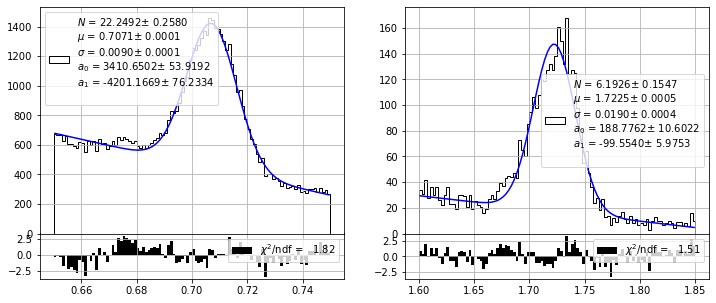

In [126]:
eranges = [ranges[name] for name in ('energy.cs', 'energy.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft.energy.values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

## Delta Z- Effect

## Cs

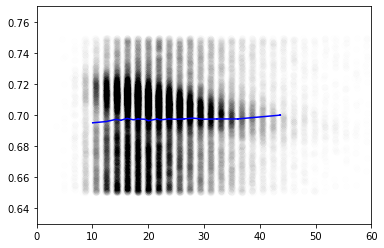

In [184]:
sel   = selections['fidutial'] & selections['energy.cs']
bins = 20

dz, ene = [dft[name][sel].values for name in ('dz_track', 'energy')]
plt.scatter(dz, ene,alpha = 0.005); plt.xlim((0., 60.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 60), percentile = True, color = 'blue');

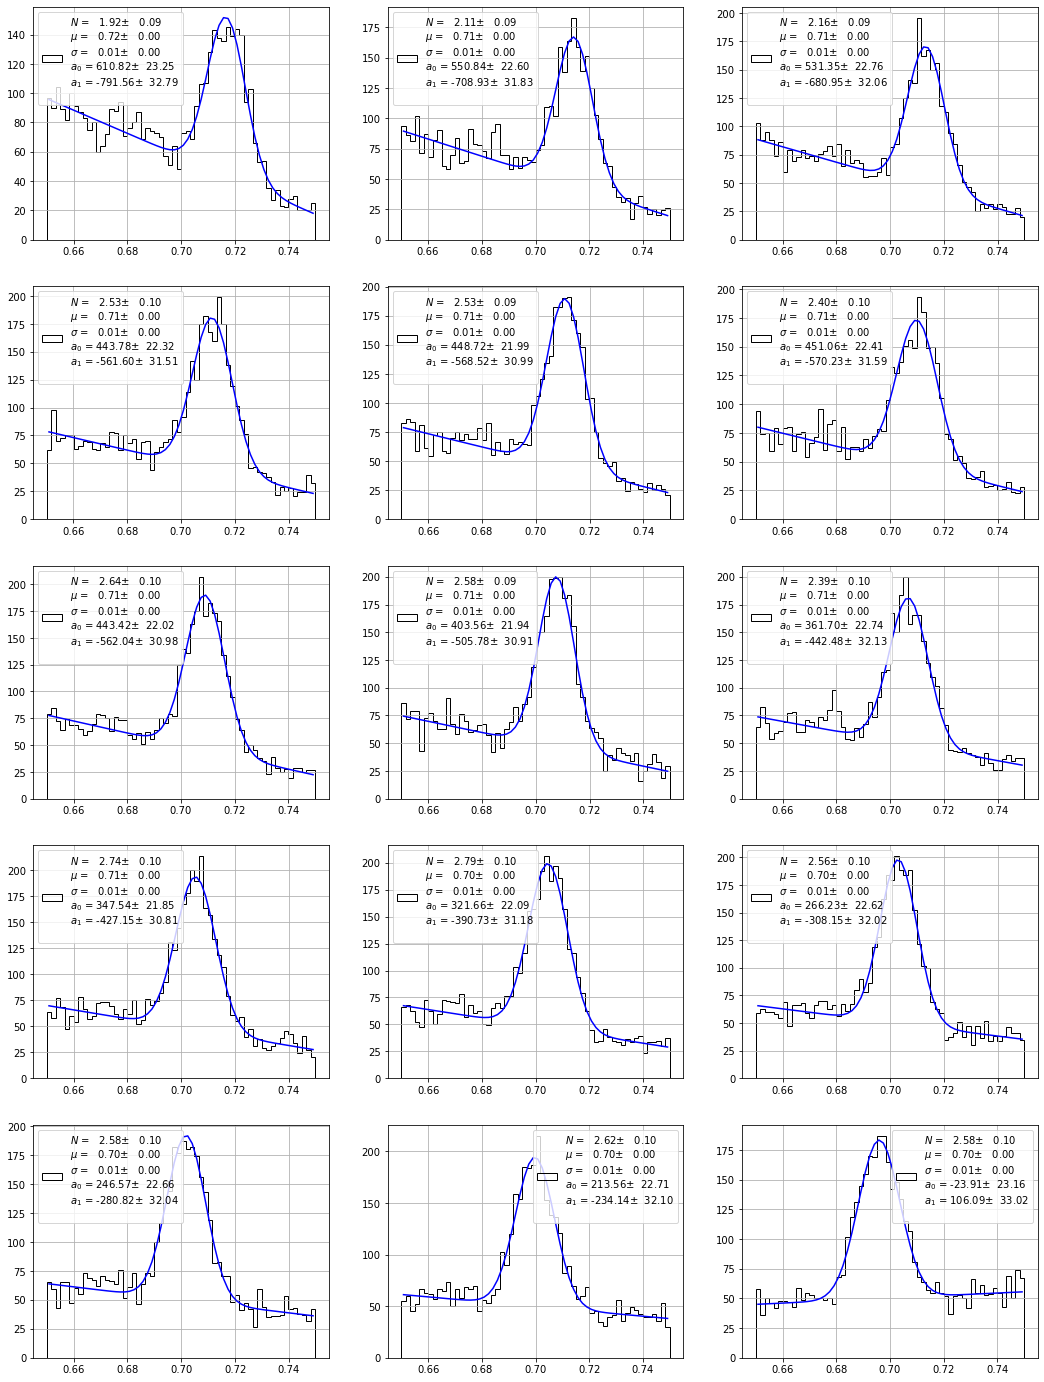

In [185]:
nbins = 16
p0s   = nbins*[(10., 0.71, 0.02, 70., -70),]
#p0s[2] = (10., 0.71, 0.02, 70., -70)
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);

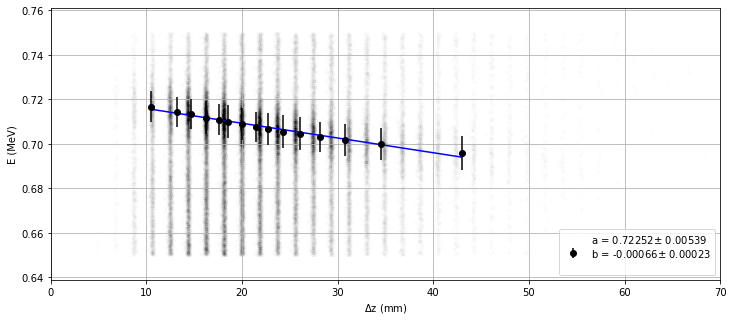

In [186]:
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.002, marker = '.'); plt.xlim(0., 70.);
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');
cs_par = par

### Double Scape

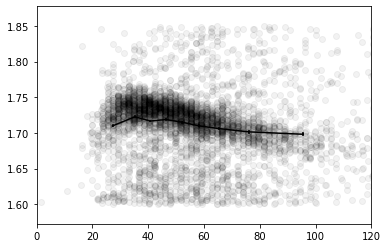

In [187]:
sel   = selections['fidutial'] & selections['energy.ds']
bins = 10

dz, ene = [dft[name][sel].values for name in ('dz_track', 'energy')]
plt.scatter(dz, ene,alpha = 0.05); plt.xlim((0., 120.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 120), percentile = True);

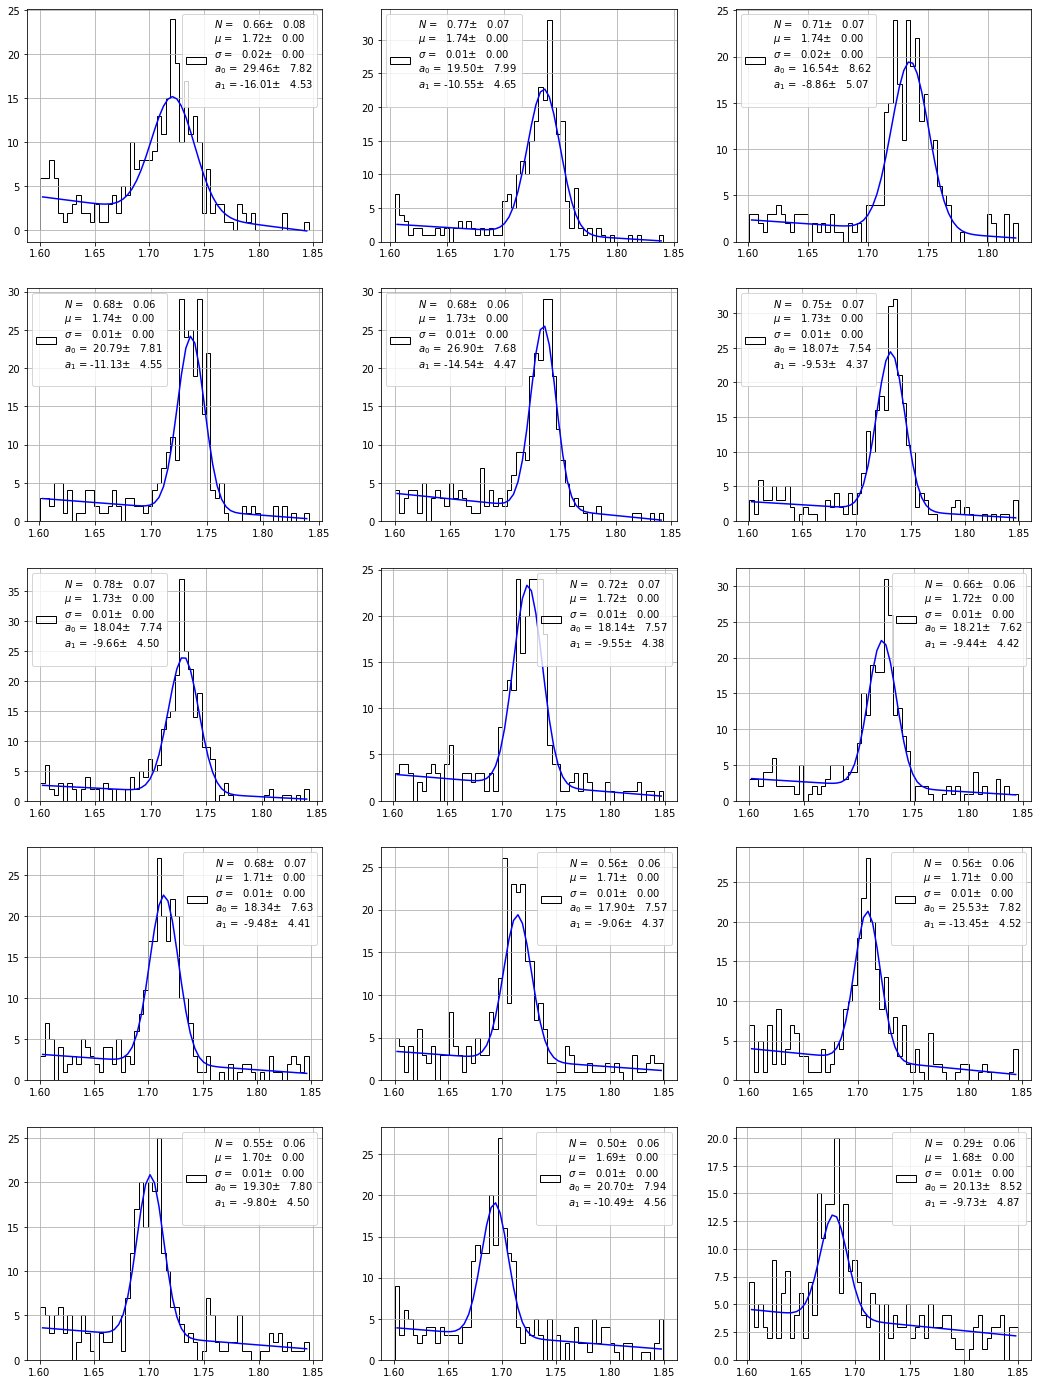

In [188]:
nbins = 16
p0s   = nbins*[None,]
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);

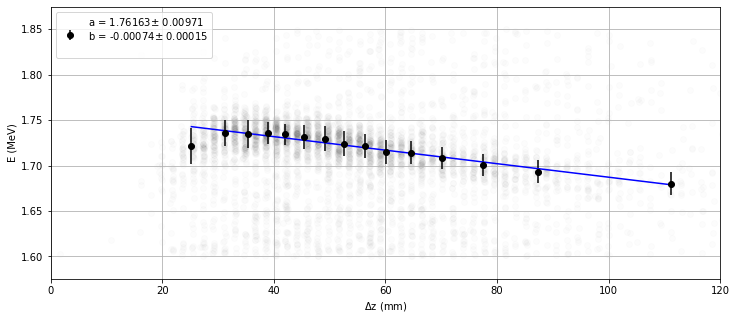

In [190]:
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.01); plt.xlim((0., 120.));
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');
ds_par = par

In [191]:
energy_ds = 2.615 - 2 * 0.511
energy_cs = 0.663

In [193]:
cor = 'cd'
ene0, slope = cs_par
scale = energy_cs/ene0
if (cor == 'ds'):
    ene0, slope = ds_par
    scale = energy_ds/ene0

print(scale)

ene, dz = [dft[name].values for name in ('energy', 'dz_track')]
enecor  = eres.dz_energy_correction(ene, dz, abs(slope), scale)
dft.enecor = enecor

0.9176186675096005


In [194]:
ranges['enecor.cs'] = (0.60, 0.70)
ranges['enecor.ds'] = (1.55, 1.)
ranges['enecor.ph'] = (2.00, 3.00)
for name in ('enecor.cs', 'enecor.ds', 'enecor.ph'):
    selections.set_range(name, ranges[name])

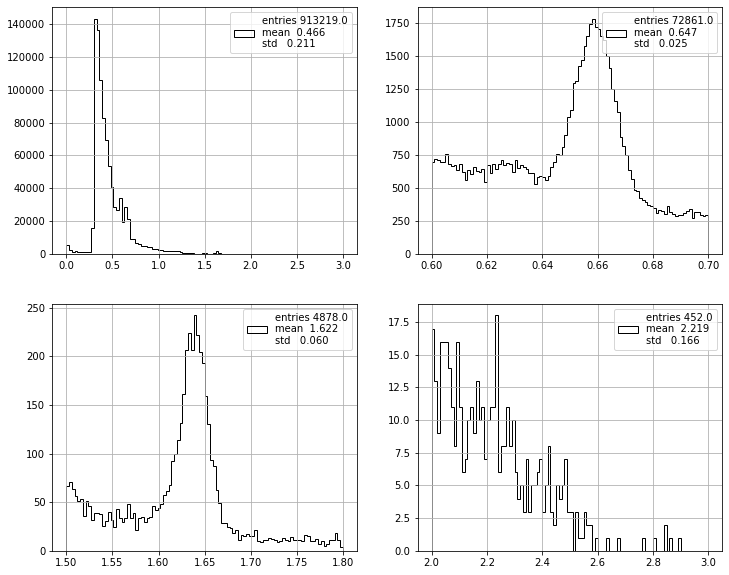

In [195]:
eranges = [ranges[name] for name in ('energy', 'enecor.cs', 'enecor.ds', 'enecor.ph')]
subplot = pltext.canvas(4)
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pltext.hist(dft.enecor, 100, range = erange);

(0.6589771291557975, 0.006857204441819421, 6.868172196884063e-05, 2.445370214732568, 0.024492814619157484)
resolution R = 2.4454 +- 0.02449
(1.6383346281142357, 0.014114367054606202, 0.00032677448708716693, 2.024541385449605, 0.04687199009757473)
resolution R = 2.0245 +- 0.04687


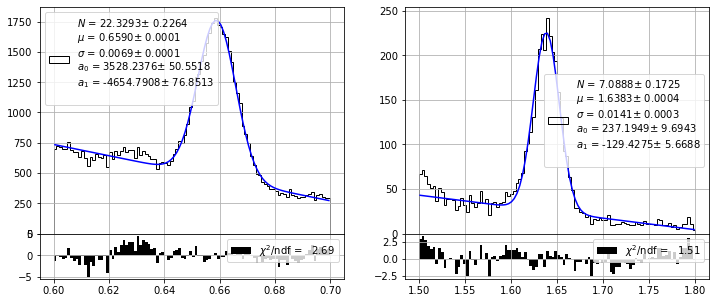

In [196]:
eranges = [ranges[name] for name in ('enecor.cs', 'enecor.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft.enecor.values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

### Check DZ correction

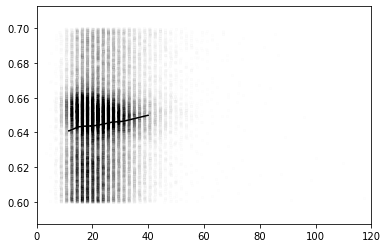

In [180]:
sel   = selections['fidutial'] & selections['enecor.cs']
bins  = 10

dz, ene = [dft[name][sel].values for name in ('dz_track', 'enecor')]
plt.scatter(dz, ene, marker = '.', alpha = 0.002); plt.xlim((0., 120.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 120), percentile = True);

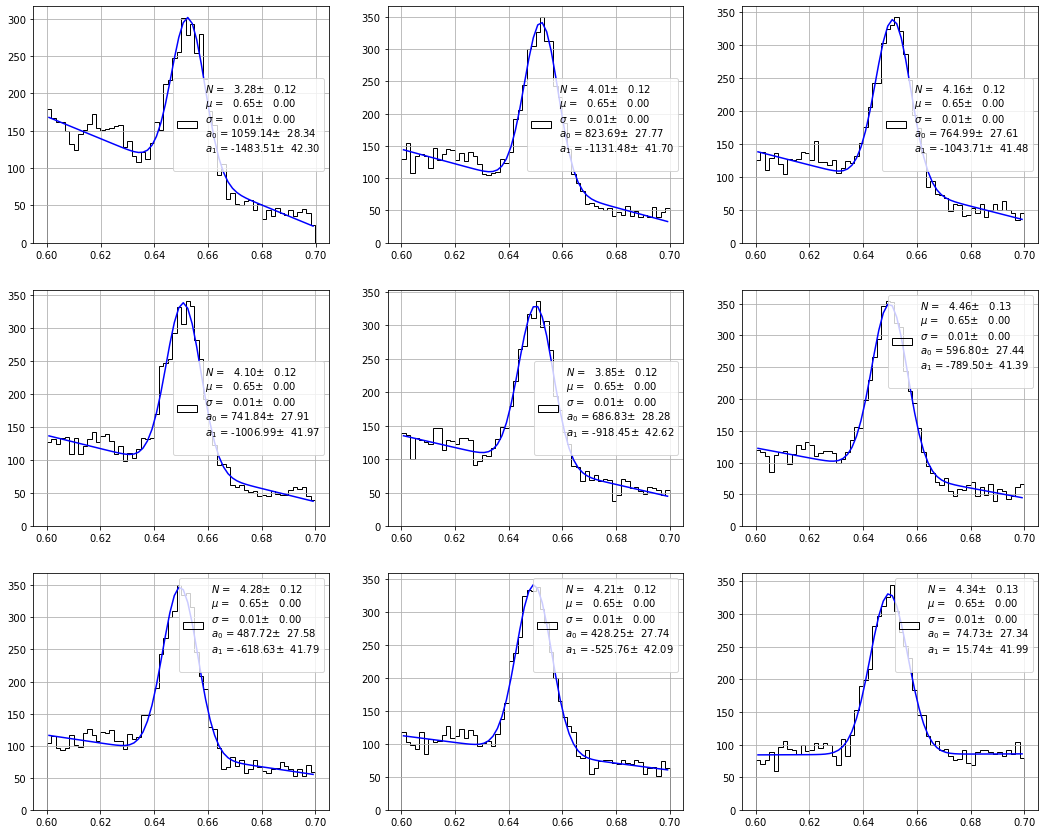

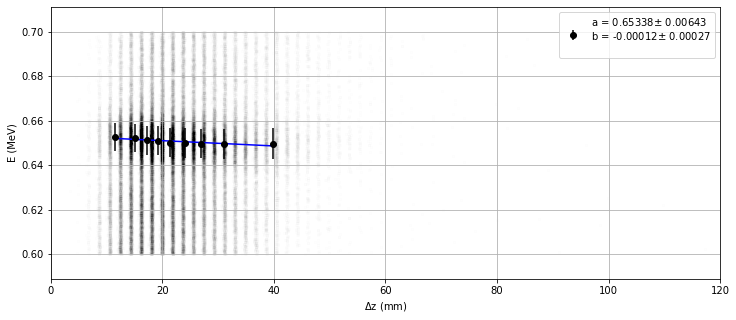

In [181]:
nbins = 10
p0s   = nbins * [(10., 0.66, 0.02, 70., -70),]
#p0s[2] = (10., 0.71, 0.02, 70., -70)
len(ene), len(dz), np.sum(np.isnan(ene)), np.sum(np.isnan(dz))
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.002, marker = '.'); plt.xlim((0., 120.));
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');

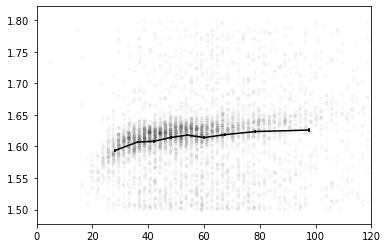

In [182]:
sel   = selections['fidutial'] & selections['enecor.ds']
bins  = 10

dz, ene = [dft[name][sel].values for name in ('dz_track', 'enecor')]
plt.scatter(dz, ene, marker = '.', alpha = 0.02); plt.xlim((0., 120.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 120), percentile = True);

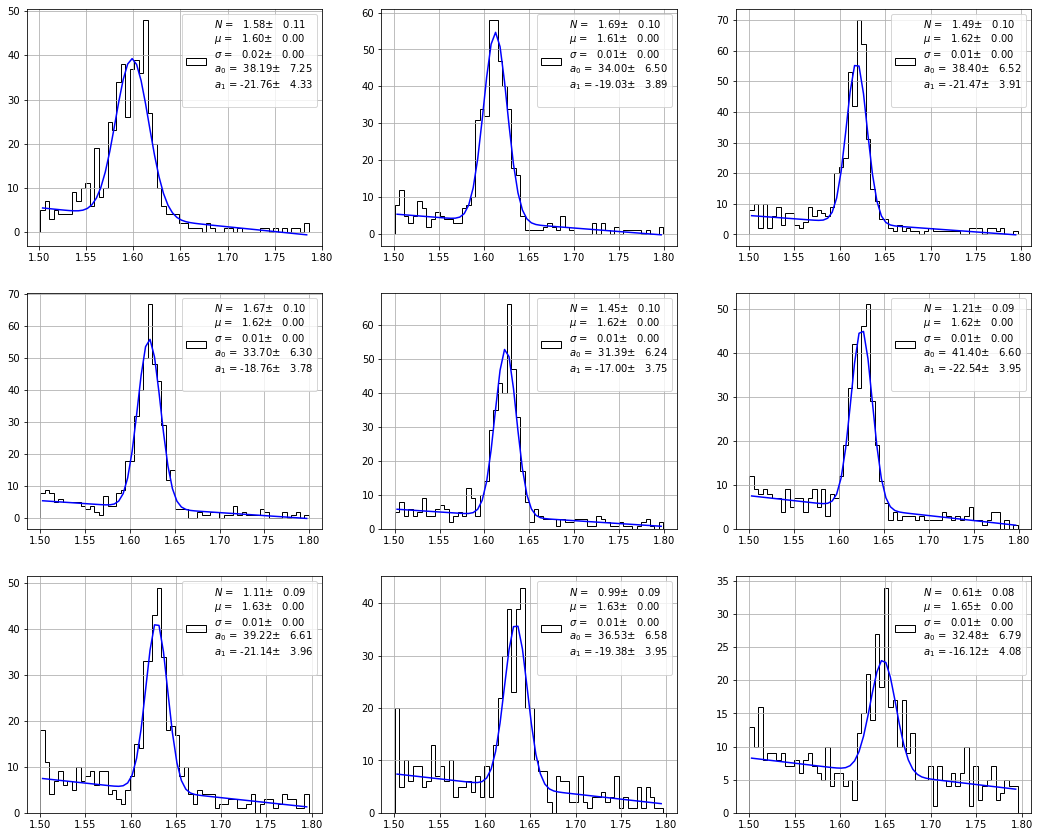

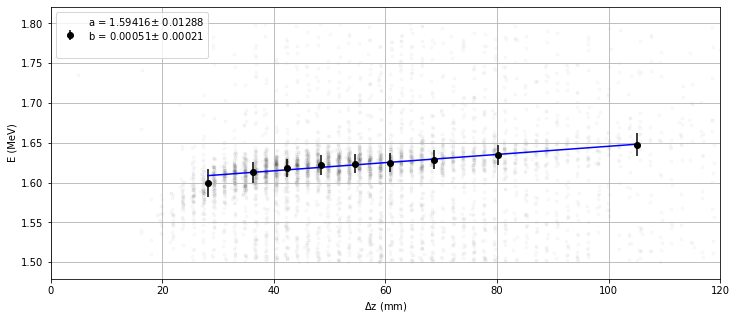

In [183]:
nbins = 10
p0s   = nbins * [(10., 1.63, 0.02, 70., -70),]
#p0s[2] = (10., 0.71, 0.02, 70., -70)
len(ene), len(dz), np.sum(np.isnan(ene)), np.sum(np.isnan(dz))
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.02, marker = '.'); plt.xlim((0., 120.));
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');